In [44]:
import pandas as pd

df = pd.read_csv("dataset.csv")
df.head()

,ClassLabel,X01,Y01,Z01,X11,Y11,Z11,X21,Y21,Z21,...,Z6219,X6319,Y6319,Z6319,X6419,Y6419,Z6419,X6519,Y6519,Z6519
0,Boy,1.0,0.547994,0.000000,1.0,0.547994,0.000000,1.0,0.547994,0.000000,...,0.071914,0.272580,0.322938,0.127316,0.228388,0.264486,0.084617,0.265310,0.313749,0.177373
1,Boy,1.0,0.857104,0.379246,1.0,0.857104,0.379246,1.0,0.857104,0.379246,...,0.265342,0.458347,0.407922,0.230979,0.368018,0.479731,0.278366,0.415877,0.466096,0.319931
2,Boy,1.0,0.852530,0.358460,1.0,0.852530,0.358460,1.0,0.852530,0.358460,...,0.252582,0.462702,0.409546,0.237752,0.368986,0.483866,0.267000,0.418716,0.471061,0.319184
3,Boy,1.0,0.778636,0.000000,1.0,0.778636,0.000000,1.0,0.778636,0.000000,...,0.003979,0.426772,0.485623,0.153090,0.321029,0.400402,0.032188,0.410688,0.467018,0.270999
4,Boy,1.0,0.589883,0.119620,1.0,0.589883,0.119620,1.0,0.589883,0.119620,...,0.380987,0.487479,0.526593,0.386855,0.465436,0.526274,0.390475,0.482003,0.520124,0.418845


In [45]:
from sklearn.model_selection import train_test_split 

y = df['ClassLabel'].values
X = df.iloc[:, 1:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

df.fillna(0, inplace=True)

In [46]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size
le_mapping

{0: 'Boy',
 1: 'Can',
 2: 'Eat',
 3: 'Fine',
 4: 'Girl',
 5: 'Help',
 6: 'How',
 7: 'Hungry',
 8: 'I',
 9: 'Mother',
 10: 'Namaste',
 11: 'Name',
 12: 'Parents',
 13: 'Sister',
 14: 'Sleep',
 15: 'This',
 16: 'You'}

In [47]:
from sklearn.preprocessing import MinMaxScaler
from pyDeepInsight import ImageTransformer, CAMFeatureSelector
import umap

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train[: , :])
X_test_norm = mms.transform(X_test[:, :])

X_train_norm = np.nan_to_num(X_train_norm)
X_test_norm = np.nan_to_num(X_test_norm)

reducer = umap.UMAP(
    n_components=2,
    metric='cosine',
    n_jobs=-1
)

pixel_size = (224,224)
it = ImageTransformer(
    feature_extractor=reducer,
    pixels=pixel_size)

c:\Users\Mello\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyDeepInsight\image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


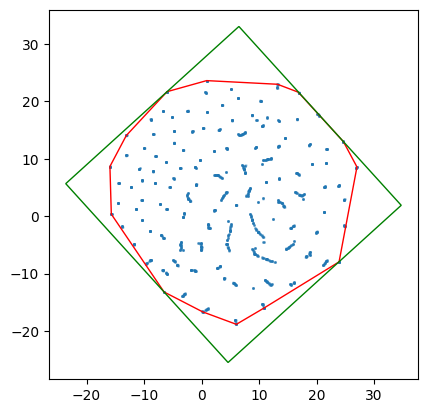

In [48]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

In [49]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=50
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [50]:
model = torch.load('cnn_model_keras2.pth')
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [55]:
input_data = X_test_tensor[100].unsqueeze(0)

In [56]:
X_test_norm[100]

array([1.       , 0.7972095, 0.       , ..., 0.       , 0.       ,
       0.       ])

In [57]:
y_test_enc[100]

0

In [58]:
with torch.no_grad(): # Disable gradient calculation for prediction
    output = model(input_data)

# The output is a tensor containing the model's predictions
# You might need to process this output to get the final prediction
# For example, for a classification task, you might need to find the class with the highest probability
predicted_class = torch.argmax(output, dim=1)

print("Predicted class:", predicted_class.item())

Predicted class: 6
